# ISW table transformation

## Import

In [52]:
import numpy as np
import pandas as pd
import re
import string
import os

import nltk

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet, stopwords

from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [53]:
data_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(data_dir, exist_ok=True)

nltk.data.path.append(data_dir)

nltk.download('punkt', download_dir=data_dir)
nltk.download('wordnet', download_dir=data_dir)
nltk.download('stopwords', download_dir=data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     D:\NaUKMA\DS\H2_python_structure_and_data\src\models..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\NaUKMA\DS\H2_python_structure_and_data\src\models..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\NaUKMA\DS\H2_python_structure_and_data\src\models..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

# Some cleaning

In [54]:
df_raw = pd.read_csv("../data/ISW.csv")

df_result = pd.DataFrame()

In [55]:
df_raw.head(10)

,date,content
0,2022-02-24,"Mason Clark, George Barros, and Kateryna Stepa..."
1,2022-02-25,"Mason Clark, George Barros, and Kateryna Stepa..."
2,2022-02-26,"Mason Clark, George Barros, and Katya Stepanen..."
3,2022-02-27,"Mason Clark, George Barros, and Kateryna Stepa..."
4,2022-02-28,"Mason Clark, George Barros, and Kateryna Stepa..."
5,2022-03-01,"Frederick W. Kagan, George Barros, and Kateryn..."
6,2022-03-02,"Mason Clark, George Barros, and Kateryna Stepa..."
7,2022-03-03,"Mason Clark, George Barros, and Kateryna Stepa..."
8,2022-03-04,"Fredrick W. Kagan, George Barros, and Kateryna..."
9,2022-03-05,"Fredrick W. Kagan, George Barros, and Kateryna..."


In [56]:
df_raw.dropna(inplace=True)

# Text Preprocessing

In [57]:
month_names = [
            'january', 'february', 'march', 'april', 'may', 'june',
            'july', 'august', 'september', 'october', 'november', 'december'
        ]

def clean_text(x):
    if isinstance(x, str):
        x = x.lower()
        x = re.sub(r'https?://\S+|www\.\S+', '', x)
        punctuation_to_remove = ''.join(c for c in string.punctuation if c != '-')
        x = re.sub(f'[{re.escape(punctuation_to_remove)}]', '', x)
        x = re.sub(r'\b(?:' + '|'.join(month_names) + r')\s+\d{1,2}\b', '', x)
        x = re.sub(r'[©®™•·]', ' ', x)
        x = re.sub(r'\s+', ' ', x).strip()
    return x

df_raw['content'] = df_raw['content'].map(clean_text)

# Text Normalization and Feature extraction

In [58]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    def __call__(self, doc):
        if not isinstance(doc, str) or not doc.strip():
            return []
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.stop_words]

In [60]:
lemming = CountVectorizer(lowercase=True, ngram_range=(2,2), tokenizer=LemmaTokenizer(), max_features=10000,
                         min_df=5, max_df=0.8)

X_lemma = lemming.fit_transform(df_raw['content'].fillna(''))

D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Redundant part for Stemming

In [61]:
class StemmerTokenizer:
    def __init__(self):
        self.sp = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
    def __call__(self, doc):
        return [self.sp.stem(t) for t in word_tokenize(doc) if t not in self.stop_words]

In [ ]:
# stemming = CountVectorizer(lowercase=True, ngram_range=(1,2), tokenizer=StemmerTokenizer())
#
# X_stemming = stemming.fit_transform(df_raw['content'].fillna(''))

# We will be using Lemmatization for the tf-idf

## As for this project we are not operating with a giant dataset, we can spend more time on converting to lemmas

*However we'll still add column with both stemming and lemming*

In [62]:
df_raw['lemma_content'] = df_raw['content'].apply(lambda x: ' '.join(LemmaTokenizer()(x)) if isinstance(x, str) else '')
df_raw['stem_content'] = df_raw['content'].apply(lambda x: ' '.join(StemmerTokenizer()(x)) if isinstance(x, str) else '')

In [64]:
tf_idf = tfidf()
X_tf_idf = tf_idf.fit_transform(X_lemma)
X_dense = X_tf_idf.toarray()

# Dimensionality Reduction
## In the graphic bellow we see that optimal amount of components is 670

In [67]:
pca = PCA(n_components=670, whiten=True, random_state=69)
X_pca = pca.fit_transform(X_dense)

Cumulative explained variance ratio:
Components 1: 0.048
Components 2: 0.076
Components 3: 0.093
Components 4: 0.108
Components 5: 0.120
Components 6: 0.129
Components 7: 0.137
Components 8: 0.145
Components 9: 0.151
Components 10: 0.157
Components 11: 0.162
Components 12: 0.167
Components 13: 0.172
Components 14: 0.176
Components 15: 0.180
Components 16: 0.184
Components 17: 0.188
Components 18: 0.192
Components 19: 0.196
Components 20: 0.199
Components 21: 0.202
Components 22: 0.205
Components 23: 0.208
Components 24: 0.212
Components 25: 0.214
Components 26: 0.217
Components 27: 0.220
Components 28: 0.223
Components 29: 0.225
Components 30: 0.228
Components 31: 0.231
Components 32: 0.233
Components 33: 0.236
Components 34: 0.238
Components 35: 0.241
Components 36: 0.243
Components 37: 0.245
Components 38: 0.248
Components 39: 0.250
Components 40: 0.252
Components 41: 0.255
Components 42: 0.257
Components 43: 0.259
Components 44: 0.261
Components 45: 0.263
Components 46: 0.265
Compon

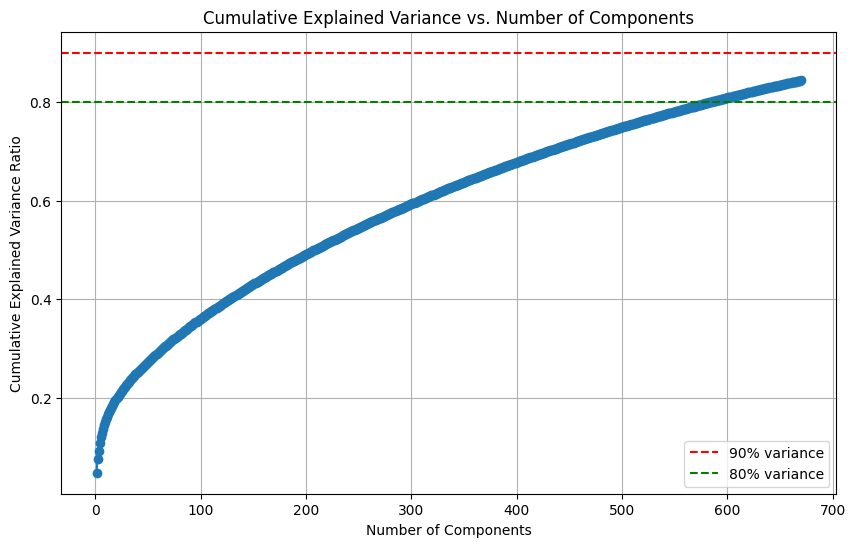

In [68]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("Cumulative explained variance ratio:")
for i, variance in enumerate(cumulative_variance_ratio):
    print(f"Components {i+1}: {variance:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [69]:
feature_names = lemming.get_feature_names_out()

In [70]:
top_n = 1000

keywords_per_doc = []
for i in range(X_pca.shape[0]):
    doc_vector = X_pca[i]
    feature_importance = np.zeros(len(feature_names))

    for i, weight in enumerate(doc_vector):
        feature_importance += abs(weight) * abs(pca.components_[i])

    top_indices = feature_importance.argsort()[-top_n:][::-1]
    top_keywords = [(feature_names[idx], feature_importance[idx] ) for idx in top_indices]

    max_importance = max([score for _, score in top_keywords])
    keywords_dict = {word: float(round(score / max_importance, 3)) for word, score in top_keywords}
    keywords_per_doc.append(keywords_dict)

df_raw['keywords'] = keywords_per_doc

In [71]:
df_raw.head(6)

,date,content,lemma_content,stem_content,keywords
0,2022-02-24,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 30...,"{'roc mp': 1.0, 'local time': 0.94, 'operation..."
1,2022-02-25,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 30...,"{'roc mp': 1.0, 'information campaign': 0.978,..."
2,2022-02-26,mason clark george barros and katya stepanenko...,mason clark george barros katya stepanenko 3pm...,mason clark georg barro katya stepanenko 3pm e...,"{'local time': 1.0, 'roc mp': 0.967, 'operatio..."
3,2022-02-27,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 4p...,"{'operational pause': 1.0, 'roc mp': 0.957, 'w..."
4,2022-02-28,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 33...,"{'roc mp': 1.0, 'information campaign': 0.976,..."
5,2022-03-01,frederick w kagan george barros and kateryna s...,frederick w kagan george barros kateryna stepa...,frederick w kagan georg barro kateryna stepane...,"{'hour russian': 1.0, 'roc mp': 0.997, 'fomin ..."


In [72]:
df_result = df_raw

df_result.to_csv("../data/ISW_vector.csv", index=False)